In [1]:
import qiskit
from zmq.backend import backend

In [2]:
qiskit.__version__

'2.0.0'

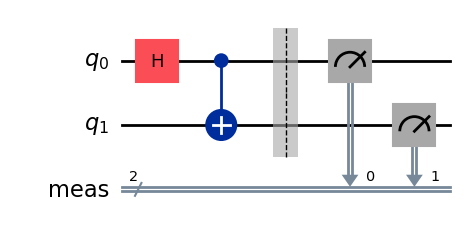

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0,q1 = qubits
circuit.h(q0)
circuit.cx(q0,q1)
circuit.measure_all()

circuit.draw("mpl")

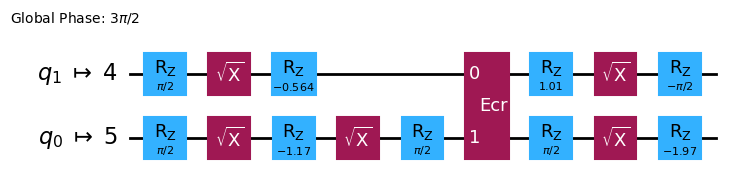

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0,q1 = qubits
circuit.h(q0)
circuit.cx(q0,q1)

QiskitRuntimeService.save_account(channel="ibm_quantum",token="462fceebeea5ac8d2830ac230674fcecc6911e77f363fa5fe80c13ec6a05350dd28fbf229271c4f4ace024901c696c66a518085b98a58e084a2fa8de53ad7a5f",overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pass_manager.run(circuit)

isa_circuit.draw("mpl", idle_wires=False)

In [2]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# ←– >>> new import <<<
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.least_busy(operational=True,
                             simulator=False,
                             min_num_qubits=127)

n_qubits = 127
mat      = np.real(random_hermitian(n_qubits, seed=1234))
circuit  = IQP(mat)
circuit.measure_all()

# now generate the pass manager for your target backend
pm    = generate_preset_pass_manager(backend=backend,
                                     optimization_level=1)

# run your circuit through it
isa_circuit = pm.run(circuit)

# submit via the new SamplerV2
sampler = Sampler(backend)
job     = sampler.run([isa_circuit])
result  = job.result()
counts  = result[0].data.meas.get_counts()   # or however you pull them out

print(counts)

{'0100100100001100001100111000010111111010010101100011111101111111101010110001000101110111001000000000110011001000010101100101000': 1, '0001100110001100011100010000100001001001001000100101010010011001110100011100010000010110001100010100001001010000100011010100000': 1, '1100000011111011000011000000001010110000100100100011100101111100000010110010110100011111000100011100010010101000000000100101010': 1, '1100100011011101110111000001100100110100100111000111010100101010100001110100010010011000000000100100000001100100101010100100000': 1, '0001000000011010010100011011001111111100100011010010111100000010010111101110110011101000011100110011011010001010111000101101100': 1, '1110011110000101010010000110000001011010100100100000001000111110101000111001010000010000010100001110000000000001111000100101010': 1, '1001111100010100000000100100110010110100111101100001010101001010000101100111100011001100000101100001000011000001101011000000010': 1, '110101000000011100111101011010001111010100000100100010001101

In [10]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
estimator = Estimator(backend)

n_qubits = 127
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
observable = SparsePauliOp("Z" * n_qubits)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()

print(f"> Expectation value: {result[0].data.evs}")
print(f"> Metadata: {result[0].metadata}")

> Expectation value: -0.02490234375
> Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


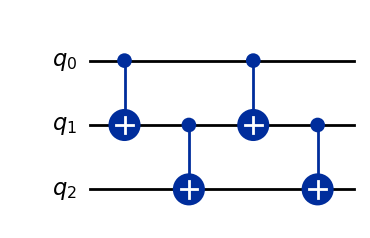

In [11]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.cx(1, 2)

qc.draw('mpl')

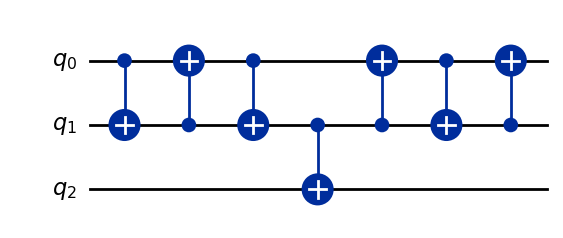

In [12]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)

qc.cx(0, 1)
qc.cx(1, 0)
qc.cx(0, 1)

qc.cx(1, 2)

qc.cx(1, 0)
qc.cx(0, 1)
qc.cx(1, 0)

qc.draw('mpl')

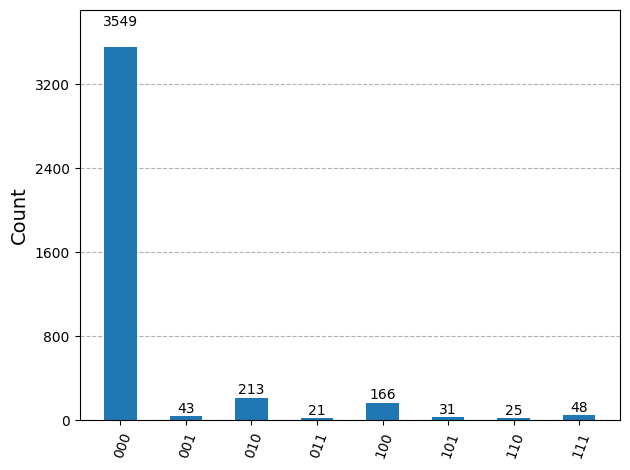

In [10]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True,
    simulator=False,
    min_num_qubits=3
)

qc = QuantumCircuit(3, 3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure([0, 1, 2], [0, 1, 2])

pm        = generate_preset_pass_manager(backend=backend, optimization_level=1)
mapped_qc = pm.run(qc)

sampler = Sampler(backend)
job     = sampler.run([mapped_qc])

result     = job.result()
counts     = result[0].data.c.get_counts()

plot_histogram(counts)

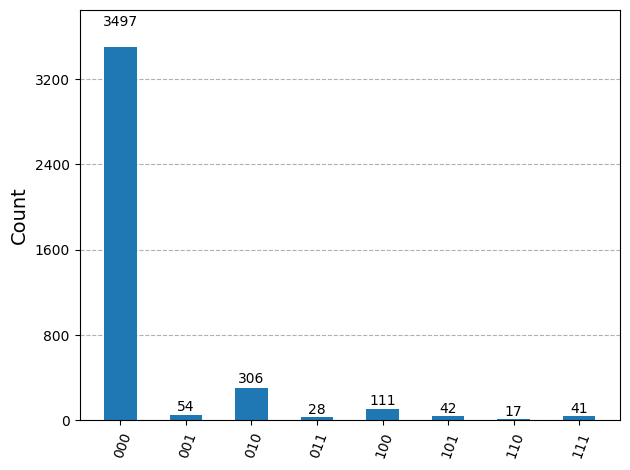

In [11]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True,
    simulator=False,
    min_num_qubits=3
)

qc = QuantumCircuit(3, 3)
qc.cx(0, 1)
qc.cx(1, 0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(1, 0)
qc.cx(0, 1)
qc.cx(1, 0)
qc.measure([0, 1, 2], [0, 1, 2])

pm        = generate_preset_pass_manager(backend=backend, optimization_level=1)
mapped_qc = pm.run(qc)

sampler = Sampler(backend)
job     = sampler.run([mapped_qc])

result     = job.result()
counts     = result[0].data.c.get_counts()

plot_histogram(counts)